# Intro

<img src="images/iiit5k.png" width="600">
<p>This notebook demonstrates training and testing a CRNN model on the <a href="https://cvit.iiit.ac.in/projects/SceneTextUnderstanding/IIIT5K.html">IIIT 5K-word dataset</a>. As the picture above shows, this dataset contains images with some text and the true text for each of these images.</p>
<p>The CRNN architecture for the image-based sequence recognition was introduced in <a href="https://arxiv.org/abs/1507.05717">(Shi et al., 2015)</a>. In this paper authors train the model on a large dataset of synthetically generated images with text and then test it on various other datasets including the IIIT5K. However, in this notebook we will both train and test the model solely on the IIIT5K for the sake of simplicity.</p>
<p>We will first explore a simpler way of creating a CRNN as a Sequential model, that doesn't take in account a width of an image (we can make this work with the IIT5K by padding all the images to the same width) and then we will also wrap it in another model, that accepts image width as one of its inputs.</p>

# Import dependencies

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pathlib import Path
from mat4py import loadmat
from PIL import Image
import os

import sys
sys.path.insert(0, "..")
import crnn

%matplotlib inline

AUTOTUNE = tf.data.experimental.AUTOTUNE

# Download and preprocess the dataset

First, let's download and extract the dataset:<br/>
(**Warning: 106 MB download!**)

In [2]:
dataset_path = tf.keras.utils.get_file(
    "IIIT5K-Word_V3.0.tar.gz",
    "http://cvit.iiit.ac.in/projects/SceneTextUnderstanding/IIIT5K-Word_V3.0.tar.gz",
    extract=True)
dataset_path = Path(dataset_path).parent / "IIIT5K"

The dataset provides true text for each image in a form of dictionaries, so that image's filename can be used as a key to retreive the true text for this image. The dictionaries come in a form of MATLAB files, so we wil use the `mat4py` package to load them (loading might take some time):

In [3]:
def load_filename_to_text_dict(dataset_path, name):
    filename_to_text = loadmat((dataset_path / f"{name}.mat").as_posix())[name]
    return {Path(path).name: text
            for path, text in zip(filename_to_text["ImgName"],
                                  filename_to_text["GroundTruth"])}

filename_to_text_train = load_filename_to_text_dict(dataset_path, "traindata")
filename_to_text_test = load_filename_to_text_dict(dataset_path, "testdata")

Since we have true text for all images, we can now create an array of all unique characters:

In [4]:
unique_chars = np.asarray(
    sorted({c for text in filename_to_text_train.values() for c in text}))
unique_chars

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'], dtype='<U1')

To make the dictionaries usable from TensorFlow graphs, we need to convert them to `StaticHashTable`'s:

In [5]:
def dict_to_tf(dictionary, default_value=""):
    keys = list(dictionary.keys())
    values = [dictionary[key] for key in keys]
    return tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys, values), default_value)

filename_to_text_train = dict_to_tf(filename_to_text_train)
filename_to_text_test = dict_to_tf(filename_to_text_test)

Let's plot some images from the train dataset with their texts from the corresponding dictionary to check that everything works as expected:

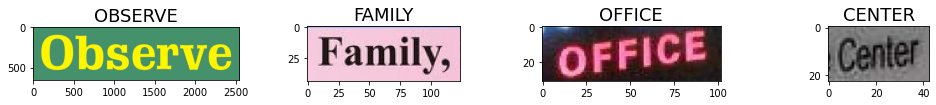

In [6]:
def plot_images(images, text, rows, columns, cmap=None, norm=None):
    for i in range(len(images)):
        image = images[i]
        plt.subplot(rows, columns, i + 1)
        plt.title(text[i], {'fontsize': 18})
        plt.imshow(image, cmap=cmap, norm=norm)

image_paths = list((dataset_path / "train").glob("*.png"))[:4]
images = [np.asarray(Image.open(path)) for path in image_paths]
text = [filename_to_text_train.lookup(tf.constant(path.name)).numpy().decode("UTF-8")
        for path in image_paths]

plt.figure(figsize=(17, 1))
plot_images(images, text, 1, 4)

Knowing the unique characters we can create `StaticHashTable`'s to encode characters with numeric labels and to decode them back:

In [7]:
labels = np.arange(unique_chars.size, dtype=np.int32)
char_to_label = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(unique_chars, labels), -1)
label_to_char = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(labels, unique_chars), "")

We also will need a function to split a tensor into separate characters before encoding:

In [8]:
def split_chars(tensor, encoding="UTF-8"):
    return tf.strings.unicode_split(tensor, encoding)

Let's encode and decode back an example word:

In [9]:
source_word = split_chars("TENSORFLOW", "UTF-8")
print("A source word:", b"".join(source_word.numpy()).decode("utf-8"))

encoded_word = char_to_label.lookup(source_word)
print("An encoded word:", encoded_word.numpy())

decoded_word = label_to_char.lookup(encoded_word)
print("A decoded word:",  b"".join(decoded_word.numpy()).decode("utf-8"))

A source word: TENSORFLOW
An encoded word: [29 14 23 28 24 27 15 21 24 32]
A decoded word: TENSORFLOW


Now we can build train and test datasets using the `tf.data` API. This is a pretty standard images loading routine, but there are still a couple of things to note:
- All images are scaled to have the same height (32 pixels)
- The resulting datasets contain image's width in addition to the image itself and its true text (we will use the width for the second model)

In [10]:
IMAGE_CHANNELS = 1 # Images will be converted to grayscale
IMAGE_HEIGHT = 32

rescaling = tf.keras.layers.experimental.preprocessing.Rescaling(
    scale=1./127.5, offset=-1)

def build_dataset(path, filename_to_text, char_to_label):
    files_ds = tf.data.Dataset.list_files((path / "*.png").as_posix(), shuffle=False)
    return files_ds.map(
        lambda image_path: process_path(image_path, filename_to_text, char_to_label),
        num_parallel_calls=AUTOTUNE)

def process_path(path, filename_to_text, char_to_label):
    image = load_image(path)
    image_width = tf.shape(image)[1]
    labels = get_labels(path, filename_to_text, char_to_label)
    return image, image_width, labels

def load_image(path):
    image_data = tf.io.read_file(path)
    image = tf.image.decode_png(image_data, channels=IMAGE_CHANNELS)
    image = rescaling(image)
    
    # Scaling image to the specified height
    source_shape = tf.shape(image)
    scale_factor = IMAGE_HEIGHT / tf.cast(source_shape[0], tf.float32)
    new_width = tf.cast(source_shape[1], tf.float32) * scale_factor
    image = tf.image.resize(image, [IMAGE_HEIGHT, new_width])
    
    return image

def get_labels(path, filename_to_text, char_to_label):
    image_name = tf.strings.split(path, os.path.sep)[-1]
    image_text = filename_to_text.lookup(image_name)
    labels = char_to_label.lookup(split_chars(image_text))
    return labels

In [11]:
source_train_ds = build_dataset(
    dataset_path / "train", filename_to_text_train, char_to_label)
source_test_ds = build_dataset(
    dataset_path / "test", filename_to_text_test, char_to_label)

print("Train dataset size:", tf.data.experimental.cardinality(source_train_ds).numpy())
print("Test dataset size:", tf.data.experimental.cardinality(source_test_ds).numpy())

Train dataset size: 2000
Test dataset size: 3000


<p>As we can see, the default train/test split of the dataset puts the majority of the images into the test set, while normally we would like to do it vice versa. Moreover, distributions of train and test sets seem to be different in some way, at least when using them both to test a model that was trained on another dataset, it performs significantly better on the train set even though it wasn't actually trained on it.</p>
<p>This factors limit a performance of a model, that is trained with the default train/test split. To fix this, both sets are concatenated together and shuffled to fix the difference of their distributions, and then they are splitted into train and test sets with a more traditional 80%/20% ratio.</p>
<p><b>Note:</b> If you are using the IIIT5K dataset to benchmark your model, you should stick to the default split in order to keep your result consistent with other models that were tested using the same dataset. However, in this notebook we are using the dataset just to demonstrate the training process, so there is no problem in using a custom split.</p>

In [12]:
reshuffled_source_ds = source_train_ds.concatenate(source_test_ds).shuffle(
    5000, seed=42, reshuffle_each_iteration=False)
source_train_ds = reshuffled_source_ds.take(4000)
source_test_ds = reshuffled_source_ds.skip(4000)

print("New train dataset size:", tf.data.experimental.cardinality(source_train_ds).numpy())
print("New test dataset size:", tf.data.experimental.cardinality(source_test_ds).numpy())

New train dataset size: 4000
New test dataset size: 1000


<p>Finally, we need to batch our datasets and configure them for performance. This is another common procedure. The only special thing here is that all images have different width (height is the same since we scaled them before) and their true text consists of different number of characters. To be able to batch tensors of different shape together, we need to use the `padded_batch()` function.</p>
<p>We could just batch everything to the maximum value in the batch, but having images tensors of different width in each batch will cause a model's graph to be retraced every time it gets a batch with a new width, drastically slowing down the model's training. To avoid this, we calculate the maximum image width in the whole dataset and pad all images to that width.</p>
<p>For the true text, however, this is not required, since loss and accuracy are not retraced for each new length of the true labels sequence, so we can just allow the `padded_batch()` to use the maximum length in each batch. And, of course, since image width value is just a scalar for all images, there is no need to pad it at all.</p>

In [13]:
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 32
IMAGE_PADDING_CONST = 0.0
LABELS_PADDING_CONST = -1
MAX_IMAGE_WIDTH = max(width.numpy() for _, width, _ in source_train_ds.concatenate(source_test_ds))

def configure_for_performance(dataset, shuffle=False, seed=None, ):
    dataset = dataset.cache()
    if shuffle:
      dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE, seed=seed)
    dataset = dataset.padded_batch(
        BATCH_SIZE, padding_values=(IMAGE_PADDING_CONST, None, LABELS_PADDING_CONST),
        padded_shapes=([IMAGE_HEIGHT, MAX_IMAGE_WIDTH, IMAGE_CHANNELS], [], [None],)
        )
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

source_train_ds = configure_for_performance(source_train_ds, shuffle=True, seed=42)
source_test_ds = configure_for_performance(source_test_ds) 

Let's plot some images with their true text from our final training dataset to make sure that everything is alright:

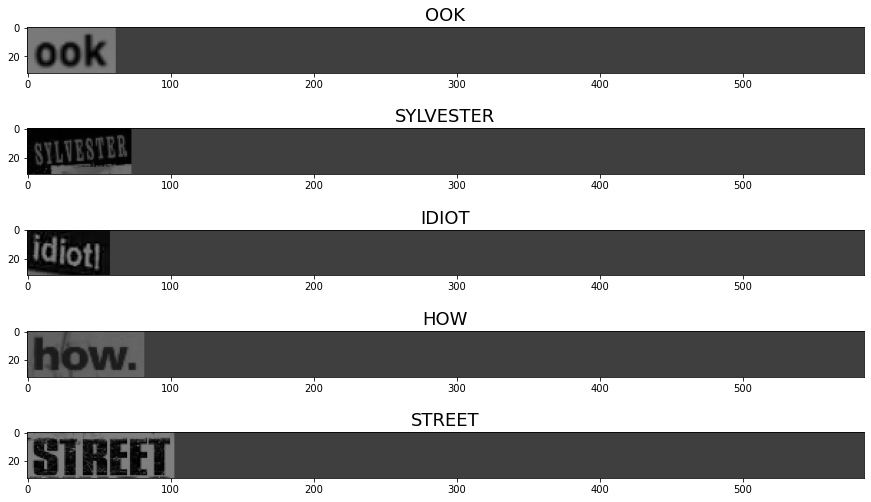

In [14]:
images, _, labels = next(iter(source_train_ds))
images, labels = images[:5], labels[:5]
images = [(np.squeeze(image) + 1) / 2 for image in images.numpy()]
text = ["".join(c.decode("UTF-8") for c in chars)
        for chars in label_to_char.lookup(labels).numpy()]
    
plt.figure(figsize=(15, 9))
plot_images(images, text, rows=5, columns=1, 
            cmap="binary", norm=matplotlib.colors.Normalize(-1, 1))

# Sequential model for fixed-length input

<p>We will start with building a CRNN as a standard Sequential model. This approach is easy and intuitive, however such model won't take in account the input image's width when calculating loss and accuracy, so it is most suitable for problems with constant-width images like, for example, CAPTCHA solving or license plate recognition.</p>
<p>However, we can still use it for the IIIT5K dataset since we have padded all images to the same width. It is worth mentioning, that I haven't actually noticed any significant difference in terms of training speed or accuracy between this model and the one, that takes in account the image's width (we will also train it later). This is probably because the model easily learns to just predict the blank character for all empty areas of images that were added during the padding process.</p>
<p>Thus, I would suggest to try this simpler model even if your dataset contains images with different width, especially if the width doesn't vary to much.</p>

First, we need to exlude image width value from the source datasets to use them for this model:

In [15]:
train_ds = source_train_ds.map(lambda image, width, text: (image, text))
test_ds = source_test_ds.map(lambda image, width, text: (image, text))

Now we can build the model. Its architecture is similar to the original paper referenced in the [Intro](#Intro), with some dropout and L2 regularization added to reduce overfitting:

In [16]:
CONV_DROPOUT = 0.35
LSTM_L2 = 0.01
DENSE_DROPOUT = 0.5
DENSE_L2 = 0.01

def build_model():
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        tf.keras.layers.MaxPool2D((2, 2)),
        tf.keras.layers.SpatialDropout2D(CONV_DROPOUT),

        tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
        tf.keras.layers.MaxPool2D((2, 2)),
        tf.keras.layers.SpatialDropout2D(CONV_DROPOUT),

        tf.keras.layers.Conv2D(256, (3, 3), activation="relu", padding="same"),
        tf.keras.layers.Conv2D(256, (3, 3), activation="relu", padding="same"),
        tf.keras.layers.MaxPool2D((2, 1)),
        tf.keras.layers.SpatialDropout2D(CONV_DROPOUT),

        tf.keras.layers.Conv2D(512, (3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512, (3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D((2, 1)),
        tf.keras.layers.SpatialDropout2D(CONV_DROPOUT),

        tf.keras.layers.Conv2D(512, (2, 2), activation="relu"),
        tf.keras.layers.SpatialDropout2D(CONV_DROPOUT),

        crnn.layers.MapToSequence(),

        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True,
                                      kernel_regularizer=tf.keras.regularizers.l2(LSTM_L2))),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True,
                                      kernel_regularizer=tf.keras.regularizers.l2(LSTM_L2))),

        tf.keras.layers.Dropout(DENSE_DROPOUT),

        tf.keras.layers.Dense(unique_chars.size + 1, activation="softmax",
                             kernel_regularizer=tf.keras.regularizers.l2(DENSE_L2))
    ])

In [17]:
model = build_model()

When compile the model we use `CTCLoss` and `CTCAccuracy`, which calculates how often a predicted text fully matches the corresponding true text:

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    loss=crnn.losses.CTCLoss(y_true_padding_const=LABELS_PADDING_CONST),
    metrics=[crnn.metrics.CTCAccuracy(y_true_padding_const=LABELS_PADDING_CONST)]
)

Let's also define some callbacks to automate the training:

In [19]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.5, patience=8, min_delta=0, verbose=1),
    tf.keras.callbacks.EarlyStopping(
        patience=20, verbose=1, restore_best_weights=True)
]

Now we are ready to train the model. Please note that training process takes a substantial amount of time even using a GPU, so you might want to skip it and just load the saved weights by uncommenting the code in the cell below.

In [ ]:
model.fit(train_ds, validation_data=test_ds, epochs=300, callbacks=callbacks)
model.save_weights(Path("saved_weights") / "crnn_iiit5k.h5")

In [22]:
# Uncomment to load pretrained 
#model.build((None, IMAGE_HEIGHT, None, IMAGE_CHANNELS))
#model.load_weights(Path("saved_weights") / "crnn_iiit5k.h5")

Let's evaluate the model:

In [23]:
model.evaluate(train_ds)

125/125 [==============================] - 5s 43ms/step - loss: 0.4891 - accuracy: 1.0000


[0.4890742599964142, 1.0]

In [24]:
model.evaluate(test_ds)

32/32 [==============================] - 1s 42ms/step - loss: 2.4263 - accuracy: 0.7870


[2.4263124465942383, 0.7870000004768372]

The model correctly recognizes text on 78.7% of the test images. The original paper reports 78.2% accuracy, but the authors used the IIIT5K dataset only for evaluation and trained their model on another dataset, so there is no direct comparison. The model overfits, however it is not as bad as it would be without dropout and L2 regularization. Variance can possibly be reduced even more by further increasing dropout and/or regularization rates, using the weight decay instead of the L2 regularization (since for the Adam optimizer they are not equivalent), etc.

Currently the model outputs CTC labels, but we can append a CTCDecode layer to it before using it for inference:

In [25]:
model = tf.keras.Sequential([
    model,
    crnn.layers.CTCDecode(label_to_char)
])

Let's now try out the model with the decoding layer:

In [26]:
image = Image.open("images/tensorflow.png").convert(mode="L")
image = image.resize((round(image.size[0] * IMAGE_HEIGHT / image.size[1]), IMAGE_HEIGHT),
                     resample=Image.BILINEAR)
image = np.asarray(image)[np.newaxis, :, :, np.newaxis]
image = rescaling(image)

In [27]:
y_pred = model(image)

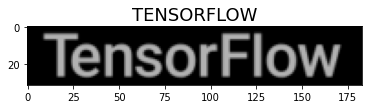

In [28]:
text = b"".join(y_pred[0].numpy()).decode("UTF-8")
plot_images(image[:, :, :, 0], [text], rows=1, columns=1, 
            cmap="binary", norm=matplotlib.colors.Normalize(-1, 1))

Well, the model got everything right with this image!

# The Functional API for a variable-width images

In this section we will build a model using the Functional API, that takes image's width as an input and passes it to loss and accuracy.

For this model we need to place tensors from the source datasets into a nested tuple, so that they all will be passed as inputs to the model:

In [29]:
train_ds = source_train_ds.map(lambda image, width, text: ((image, width, text),))
test_ds = source_test_ds.map(lambda image, width, text: ((image, width, text),))

The same sequential model will be used as a "core" model:

In [30]:
core_model = build_model()

We will wrap the core model in another model built with the Functional API. It will take an image, its width and its true text as inputs, "convert" the image to predictions using the core model and then pass all this three tensors to loss and accuracy layers. Note that loss and accuracy layers are "transparent" (they return the same predictions that were passed to them), so we can just stack them after the core model. After training this new model, you can use just the core model for inference.

In [31]:
image_input = tf.keras.layers.Input((IMAGE_HEIGHT, None, IMAGE_CHANNELS), name="image_input")
image_width_input = tf.keras.layers.Input(tuple(), name="image_width_input")
labels_input = tf.keras.layers.Input((None,), name="labels_input")

y_true = labels_input
y_pred = core_model(image_input)

y_pred = crnn.layers.CTCLossLayer(y_true_padding_const=LABELS_PADDING_CONST)(
    y_true, y_pred, image_input, image_width_input)
y_pred = crnn.layers.CTCAccuracyLayer(y_true_padding_const=LABELS_PADDING_CONST)(
    y_true, y_pred, image_input, image_width_input)

model = tf.keras.Model(inputs=[image_input, image_width_input, labels_input],
                       outputs=y_pred)

Since we've already added loss and accuracy layers, only an optimizer need to be specified when compiling the model: 

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

Now we are all set up to train the model:

In [ ]:
model.fit(train_ds, validation_data=test_ds, epochs=300, callbacks=callbacks)
model.save_weights(Path("saved_weights") / "crnn_iiit5k_var_width.h5")

In [36]:
# Uncomment to load pretrained 
#model.build((None, IMAGE_HEIGHT, None, IMAGE_CHANNELS))
#model.load_weights(Path("saved_weights") / "crnn_iiit5k_var_width.h5")

Let's evaluate the model:

In [37]:
model.evaluate(train_ds)

125/125 [==============================] - 5s 43ms/step - loss: 0.4332 - accuracy: 1.0000


[0.4332295060157776, 1.0]

In [38]:
model.evaluate(test_ds)

32/32 [==============================] - 1s 42ms/step - loss: 2.2707 - accuracy: 0.7980


[2.2706708908081055, 0.7979999780654907]